# Chest X-Ray Pneumonia Dignosis using CNN

## What is Pneumonia
Pneumonia is an inflammatory condition of the lung primarily affecting the small air sacs known as alveoli. Symptoms typically include some combination of productive or dry cough, chest pain, fever, and difficulty breathing. Pneumonia is caused by infection with viruses or bacteria, and less commonly by other microorganisms. Pneumonia is typically diagnosed based on a combination of physical signs and often a chest X-ray.

In this project we will create a Neural Network to classify Chest X-Ray scans from patients with pneumonia.

## Import the Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
from keras.models import load_model

import tensorflow as tf

import os

## Load Dataset
The dataset is downloaded from [kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) and organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

In [2]:
train_folder = "C:/Users/newsh/OneDrive/Desktop/Data Science/Projects/Chest X-Ray Images Pneumonia/chest_xray/train"
test_folder = "C:/Users/newsh/OneDrive/Desktop/Data Science/Projects/Chest X-Ray Images Pneumonia/chest_xray/test"
val_folder = "C:/Users/newsh/OneDrive/Desktop/Data Science/Projects/Chest X-Ray Images Pneumonia/chest_xray/val"

In [3]:
# Directory of normal train data
train_n = train_folder + "/NORMAL/"

# Directory of penumonia train data
train_p = train_folder + "/PNEUMONIA/"

# Directory of normal test data
test_n = test_folder + "/NORMAL/"

# Directory of penumonia test data
test_p = test_folder + "/PNEUMONIA/"

# Directory of normal validation data
val_n = val_folder + "/NORMAL/"

# Directory of penumonia validation data
val_p = val_folder + "/PNEUMONIA/"

## Plot data
Let's plot the data in each caregories.

In [4]:
# Count the number of each file
count_train_n = len(os.listdir(train_n))
count_train_p = len(os.listdir(train_p))

count_test_n = len(os.listdir(test_n))
count_test_p = len(os.listdir(test_p))

count_val_n = len(os.listdir(val_n))
count_val_p = len(os.listdir(val_p))

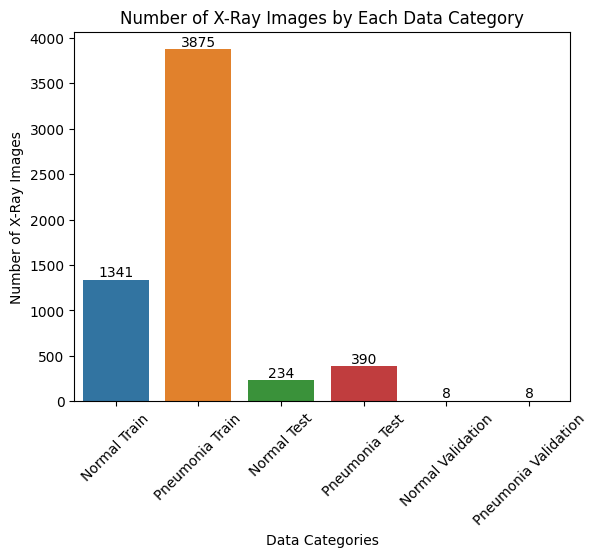

In [5]:
count_total = {'Normal Train':count_train_n, 'Pneumonia Train':count_train_p,
               'Normal Test':count_test_n, 'Pneumonia Test':count_test_p, 
               'Normal Validation':count_val_n, 'Pneumonia Validation':count_val_p}

# Visulize the number of x-ray images for each data category using seaborn library
sns.barplot(x=list(count_total.keys()), y=list(count_total.values()))
plt.xlabel('Data Categories')
plt.ylabel('Number of X-Ray Images')
plt.title('Number of X-Ray Images by Each Data Category')
plt.xticks(rotation=45)

# Add values on the plot
for i, v in enumerate(count_total.values()):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

## Looks at some random pictures

Train normal x-ray image title: IM-0214-0001.jpeg
Train pneumonia x-ray image title: person1389_virus_2387.jpeg


Text(0.5, 1.0, 'Pneumonia')

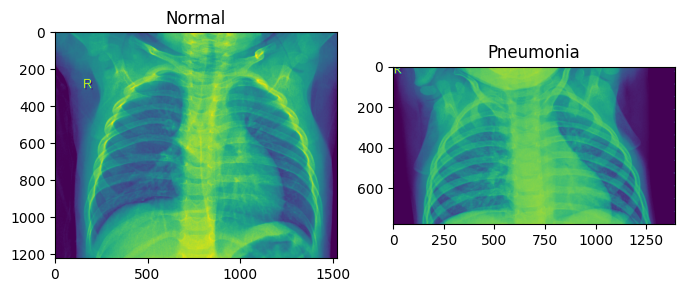

In [6]:
# Select normal train pic
rand_norm = np.random.randint(0, count_train_n)
norm_pic = os.listdir(train_n)[rand_norm]
norm_pic_dir = train_n + norm_pic
print(f"Train normal x-ray image title: {norm_pic}")


# Select pneumonia train pic
rand_pneu = np.random.randint(0, count_train_p)
pneu_pic = os.listdir(train_p)[rand_pneu]
pneu_pic_dir = train_p + pneu_pic
print(f"Train pneumonia x-ray image title: {pneu_pic}")

# Load images
norm_load = Image.open(norm_pic_dir)
pneu_load = Image.open(pneu_pic_dir)

# Plot images
plt.figure(figsize=(8,5))
plt1 = plt.subplot(1,2,1)
plt1.imshow(norm_load)
plt1.set_title('Normal')

plt2 = plt.subplot(1,2,2)
plt2.imshow(pneu_load)
plt2.set_title('Pneumonia')

## Data Preprocessing
### Data Augmentation

Data augmentation is a technique that increase the size of a training dataset by applying various transformations to existing data samples. 

The purpose of data augmentation is to introduce diversity and variability into the training data, which can help improve the performance and generalization of machine learning models. By generating new training examples from existing ones, data augmentation can reduce overfitting and enhance the model's ability to recognize and generalize patterns from unseen data.

In the context of image data, common data augmentation techniques include:

    1. Rotation: Rotating the image by a certain degree to introduce variations in object orientation.
    2. Translation: Shifting the image in horizontal or vertical directions to change the position of objects.
    3. Scaling: Resizing the image to a larger or smaller size to simulate variations in object size.
    4. Flipping: Mirroring the image horizontally or vertically to capture different viewpoints.
    5. Shearing: Applying a shear transformation to the image to simulate distortions in shape.
    6. Zooming: Zooming in or out of the image to simulate variations in object scale.
    7. Noise addition: Adding random noise to the image to enhance its robustness to noise in real-world scenarios.

In [7]:
# Create ImageDataGenerator
image_generator = ImageDataGenerator(
    rotation_range=10,           # Rotate images by a random degree between -10 and +10
    width_shift_range=0.1,       # Shift the width of the image randomly by up to 10%
    height_shift_range=0.1,      # Shift the height of the image randomly by up to 10%
    shear_range=0.2,             # Apply random shearing transformations
    zoom_range=0.2,              # Apply random zooming transformations
    horizontal_flip=True,        # Flip images horizontally
    vertical_flip=False,         # Do not flip images vertically (specific to X-ray images)
    rescale=1./255               # Rescale pixel values to [0, 1] range
)

The ImageDataGenerator is configured with various augmentation parameters suitable for X-ray images. Notably, vertical_flip is set to False to avoid flipping X-ray images vertically since such a transformation is not meaningful for these images.

In [8]:
# Train data augmentation
train_generator = image_generator.flow_from_directory(
    directory=train_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Specify class_mode as 'binary' for two classes
    classes=['NORMAL', 'PNEUMONIA']  # Specify the class labels based on the folder names
)

Found 5216 images belonging to 2 classes.


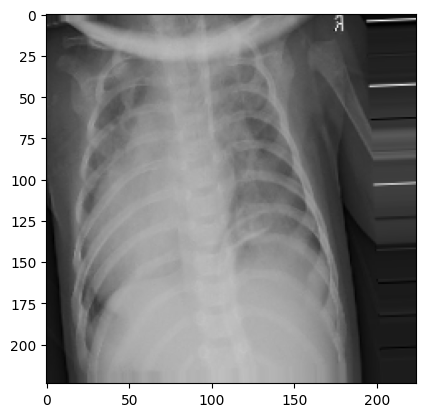

In [9]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

In [10]:
# Validation data augmentation
valid_generator = image_generator.flow_from_directory(
    directory=val_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Specify class_mode as 'binary' for two classes
    classes=['NORMAL', 'PNEUMONIA']  # Specify the class labels based on the folder names
)

Found 16 images belonging to 2 classes.


In [11]:
# Test data augmentation
test_generator = image_generator.flow_from_directory(
    directory=test_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Specify class_mode as 'binary' for two classes
    classes=['NORMAL', 'PNEUMONIA']  # Specify the class labels based on the folder names
)

Found 624 images belonging to 2 classes.


Now let's check class imbalance in the data.

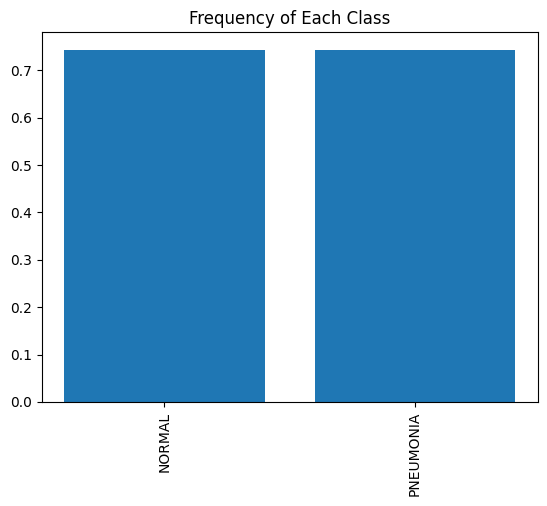

In [12]:
# Plot frequency of normal and pneumonia
plt.xticks(rotation=90)
plt.bar(x=train_generator.class_indices.keys(), height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

As we can see our data is class balanced now.

## Training The Model

### Pre-trained Model

Next, we will use a pre-trained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model which we can load directly from Keras. The `weight` parameter specifies the path to the pre-trained weights file. Then add two layers on top of pre-trained model:
1. A `GlobalAveragePooling2D` layer to get the average of the last convolution layers from DenseNet121.
2. A `Dense` layer with `sigmoid` activation to get the prediction logits for each of our classes.

We can set our custom loss function for the model by specifying the `loss` parameter in the `compile()` function.

In [13]:
# create the base pre-trained model
base_model = DenseNet121(weights='models/nih/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(units=1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy')

### Train Model
Now, we can train the model using a traning generator and valid it using a validation generator. 

Epoch 1/4
163/163 [==============================] - 1446s 9s/step - loss: 0.1575 - val_loss: 0.6189
Epoch 2/4
163/163 [==============================] - 1389s 9s/step - loss: 0.1164 - val_loss: 0.3697
Epoch 3/4
163/163 [==============================] - 1311s 8s/step - loss: 0.0947 - val_loss: 2.7934
Epoch 4/4
163/163 [==============================] - 1337s 8s/step - loss: 0.0941 - val_loss: 1.9108


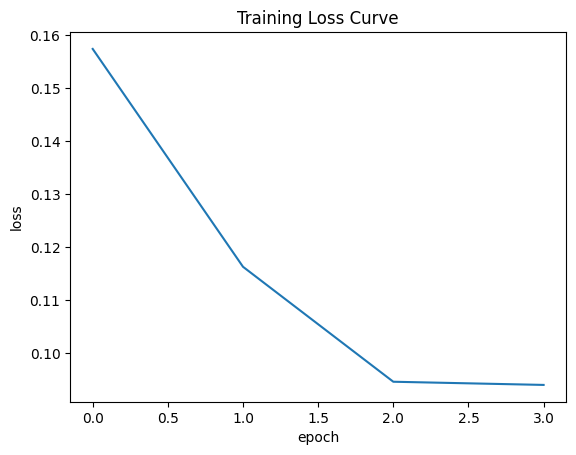

In [14]:
# Train the model
history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=len(train_generator), 
                              validation_steps=len(valid_generator), 
                              epochs = 3)

# plot training loss
plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

In [15]:
# Model parameters
model_parameters = model.get_weights()
np.save('model_parameters.npy', model_parameters)

C:\Users\newsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## Prediction and Evaluation

Let's evaluate the model using our test set. We can use the `predict_generator` function to generate the predictions for the images in our test set.

In [16]:
predicted_vals = model.predict(test_generator, steps = len(test_generator))

20/20 [==============================] - 52s 2s/step


Calculate the accuracy by comparing the predicted classes with the true labels and computing the mean.

In [17]:
# Convert the predicted probabilities to binary values (0 or 1)
predicted_classes = (predicted_vals > 0.5).astype(int)

# Convert the ground truth labels to binary values (0 or 1)
true_classes = test_generator.classes.astype(int)

# Calculate accuracy
accuracy = (predicted_classes == true_classes).mean()
print(f"Accuracy of the model is: {accuracy * 100} %" )

Accuracy of the model is: 46.394230769230774 %


The resulting accuracy value will indicate the proportion of correctly classified samples in the test set.

### Specificity and Sensitivity

By comparing the predicted classes and true labels, you can calculate the number of True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN). Then, specificity is calculated as the ratio of TN to the sum of TN and FP, and sensitivity is calculated as the ratio of TP to the sum of TP and FN.

The resulting specificity and sensitivity values represent the model's performance in correctly identifying negative cases and positive cases, respectively.

In [18]:
# Calculate True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
TP = ((predicted_classes == 1) & (true_classes == 1)).sum()
TN = ((predicted_classes == 0) & (true_classes == 0)).sum()
FP = ((predicted_classes == 1) & (true_classes == 0)).sum()
FN = ((predicted_classes == 0) & (true_classes == 1)).sum()

# Calculate specificity and sensitivity
specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)


In [19]:
print(f"Specificity of the model is: {specificity}")
print(f"sensitivity of the model is: {sensitivity}")

Specificity of the model is: 0.6442307692307693
sensitivity of the model is: 0.3557692307692308


### PPV and NPV

PPV is calculated as the ratio of TP to the sum of TP and FP, and NPV is calculated as the ratio of TN to the sum of TN and FN.

The resulting PPV and NPV values represent the model's performance in correctly predicting positive cases and negative cases, respectively.

In [20]:
# Calculate Positive Predictive Value (PPV) and Negative Predictive Value (NPV)
PPV = TP / (TP + FP)
print(f"PPV of the model is: {PPV}")

NPV = TN / (TN + FN)
print(f"NPV of the model is: {NPV}")


PPV of the model is: 0.625
NPV of the model is: 0.375


### ROC Curve

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The ideal point is at the top left, with a true positive rate of 1 and a false positive rate of 0. The various points on the curve are generated by gradually changing the threshold.

In [21]:
from sklearn.metrics import roc_curve, auc

# Compute False Positive Rate (FPR), True Positive Rate (TPR), and the corresponding threshold values
fpr, tpr, thresholds = roc_curve(true_classes, predicted_vals)

# Compute Area Under the Curve (AUC)
auc_score = auc(fpr, tpr)

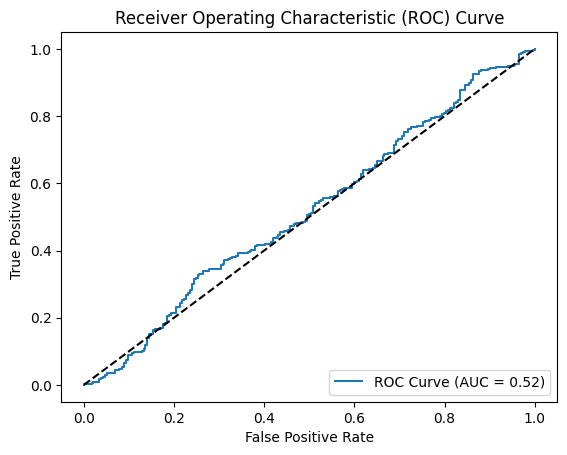

In [22]:
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Confidence Interval

### F1 Score

F1 score is the harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.

In [49]:
from sklearn.metrics import f1_score


f1 = f1_score(true_classes, predicted_classes)
print(f"F1 score of the model is: {f1}")

F1 score of the model is: 0.7448559670781894


### Calibration